In [1]:
# Importing required Packages
import pickle
import re
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import gensim

In [2]:
# Loading the dataset
dataset = pickle.load(open('AIML_DS_NEWSGROUPS_PICKELFILE.pkl','rb'))
print(type(dataset))
print(dataset.keys())

<class 'dict'>
dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


In [3]:
train_set = {}
test_set = {}
new_dataset = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    new_dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]
    
# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in new_dataset:
    split = int(0.95*len(new_dataset[k]))
    train_set[k] = new_dataset[k][0:split]
    test_set[k] = new_dataset[k][split:]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

In [4]:
emails = [email for email_list in [train_set[key] for key in train_set] for email in email_list]

In [5]:
dictionary = defaultdict(int)
for sentences in emails:
    for word in re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(sentences)):
        dictionary[word] += 1

sorted_words = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
print("Top-10 most frequent words:")
for word in sorted_words[:10]:
    print(word)

print('----------------------------')
print("10 least frequent words:")
for word in sorted_words[-10:]:
    print(word)

Top-10 most frequent words:
('the', 226860)
('and', 90621)
('that', 62088)
('for', 43546)
('you', 42430)
('from', 35358)
('this', 31001)
('not', 28645)
('have', 28519)
('are', 28355)
----------------------------
10 least frequent words:
('apokteiuo', 1)
('odessy', 1)
('reedited', 1)
('stumps', 1)
('morsel', 1)
('roston', 1)
('nutball', 1)
('tillage', 1)
('honorably', 1)
('beecher', 1)


In [6]:
len(dictionary)

89599

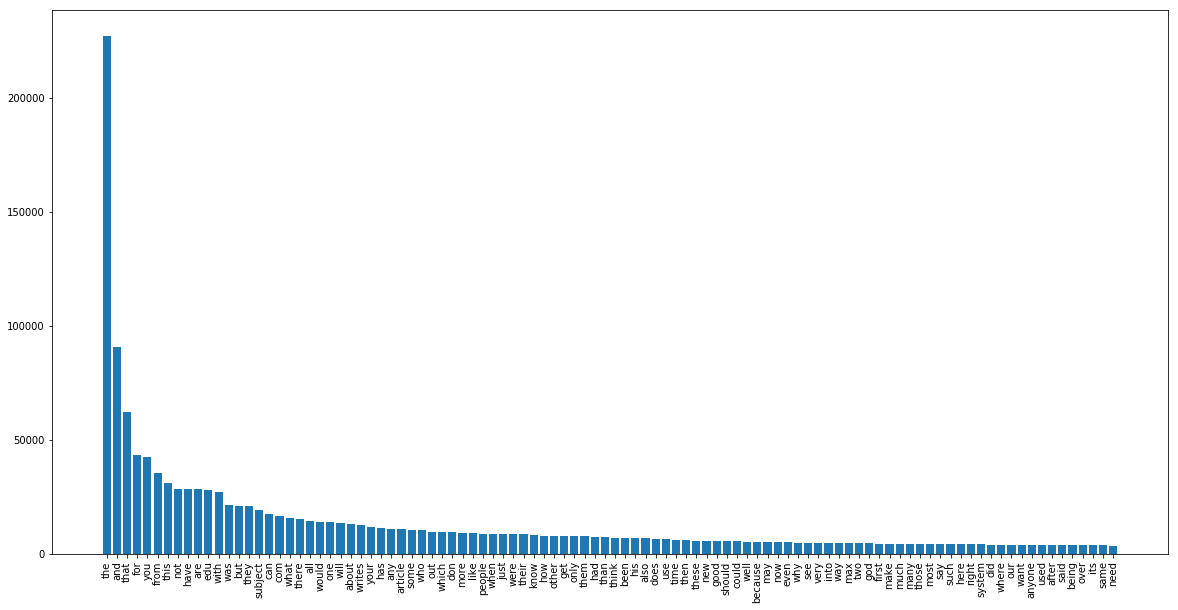

In [7]:
%matplotlib inline  

fig = plt.figure()
fig.set_size_inches(20,10)

plt.bar(range(len(sorted_words[:100])), [v for k, v in sorted_words[:100]] , align='center')
plt.xticks(range(len(sorted_words[:100])), [k for k, v in sorted_words[:100]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [8]:
processed = defaultdict(int)

ignore_frequent = 25 #top 25
freq_thresh = 100 #ignore words with freq -gt 100
feature_num = 0 #for assigigning feature num
for word,word_frequency in sorted_words[ignore_frequent:]:
    if word_frequency > freq_thresh:
        processed[word] = feature_num
        feature_num += 1
word_vector_size = len(processed)

In [9]:
word_vector_size

4096

In [10]:
def convert_to_BoW(dataset, number_of_documents):
    bow_representation = np.zeros((number_of_documents, word_vector_size))
    labels = np.zeros((number_of_documents, 1))
    
    i = 0
    for label, class_name in enumerate(dataset):
        
        # For each file
        for f in dataset[class_name]:
            
            # Read all text in file
            text = ' '.join(f).split(' ')
            
            # For each word
            for word in text:
                if word in processed:
                    bow_representation[i, processed[word]] += 1
            
            # Label of document
            labels[i] = label
            
            # Increment document counter
            i += 1
    
    return bow_representation, labels

In [11]:
train_bow_set, train_bow_labels = convert_to_BoW(train_set, n_train)
test_bow_set, test_bow_labels = convert_to_BoW(test_set, n_test)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
model.fit(train_bow_set, train_bow_labels)

remote\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [13]:
model.score(test_bow_set, test_bow_labels) # This cell may take some time to finish its execution

0.4378947368421053